Grad Cam on Any Deep Network
------------------------------------
1) Define model
2) get predicted class
3) Pass layer_name to grad_cam function
4) Outputs heatmap overlayed on input image


In [29]:
from keras.preprocessing.image import load_img, img_to_array
import numpy as np
import scipy
import argparse
import cv2
from keras.applications import inception_resnet_v2
from keras.applications import resnet50
from keras import backend as K
import matplotlib.pyplot as plt
%matplotlib inline

In [24]:
K.set_learning_phase(0)

In [3]:
model = resnet50.ResNet50(weights='imagenet')

In [4]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 112, 112, 64) 0           bn_conv1[0][0]                   
__________________________________________________________________________________________________
max_poolin

In [5]:
layer_dict = dict([(layer.name, layer) for layer in model.layers])


In [6]:
def load_image(image_path):
    # Util function to open, resize and format pictures
    # into appropriate tensors.
    img = load_img(image_path, target_size=(224, 224))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = resnet50.preprocess_input(img)
    return img

In [7]:
preprocessed_image = load_image("/home/nishanth/Documents/index.jpeg")
org_img = cv2.resize(cv2.imread("/home/nishanth/Documents/index.jpeg"),(224,224))

In [8]:
predictions = model.predict(preprocessed_image)
top_1 = resnet50.decode_predictions(predictions)[0][0]
print('Predicted class:')
print('%s (%s) with probability %.2f' % (top_1[1], top_1[0], top_1[2]))

Predicted class:
African_elephant (n02504458) with probability 0.83


In [9]:
predicted_class = np.argmax(predictions)

In [13]:
def grad_cam(input_model, image, org_img, category_index, layer_name):
    

    mod_outputs = input_model.output[0, category_index]
    conv_output = input_model.get_layer(layer_name).output
    grads = K.gradients(mod_outputs, conv_output)[0]
    gradient_function = K.function([input_model.input], [conv_output, grads])
    output, grads_val = gradient_function([image])
    output, grads_val = output[0, :], grads_val[0, :, :, :]
    weights = np.mean(grads_val, axis = (0, 1))
    cam = np.ones(output.shape[0 : 2], dtype = np.float32)
    cam = np.dot(output, weights)
    cam = cv2.resize(cam, (224, 224))
    cam = np.maximum(cam, 0)
    heatmap = cam / np.max(cam)
    cam = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)
    #cam = np.float32(cam) 
    #grad_cam_out = 0.3 * np.uint8(255 * cam / np.max(cam)) + 0.7 * org_img
    grad_cam_out = 0.3 * cam + 0.7 * org_img
    return grad_cam_out


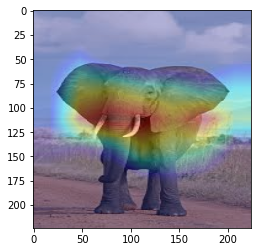

In [22]:
heatmap_out = grad_cam(model, preprocessed_image, org_img, predicted_class, "res5c_branch2c")
im = cv2.cvtColor(heatmap_out.astype('uint8'), cv2.COLOR_BGR2RGB)
plt.imshow(im)